In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## Key parameters:
#### Stock universe: 517 HSCI constituents as of 02/20/2025
#### Time window: from 12/31/2020 onwards
#### Factor definition: Past 12-month return minus Past 1-month return
#### Rebalancing methodology: At each month-end trading day, compute momentum factor value, rebalance by longing top 50 momentum score stock and shorting bottom 50 momentum score stock at the open price of next trading day (start of next month). 

In [2]:
"""
Read and print the constituents tickers that make up HSCI as of 2025.02.20.
I obtained the HSCI index constituents using my University's Bloomberg account.
When running the code, make sure the csv file is in the current directory.
"""
### Load and clean ticker symbols ###
index_data = pd.read_csv('HSCI.csv').iloc[:,:2]
index_data['Ticker'] = index_data['Ticker'].str.split(' ', expand=True)[0].astype('int')
### Sort by ticker value and add zero paddings ###
index_data = index_data.sort_values(by='Ticker', ignore_index=True)
index_data['Ticker'] = index_data['Ticker'].astype('string').str.zfill(4) + '.HK'
index_data.head(10)

,Ticker,Name
0,0001.HK,CK Hutchison Holdings Ltd
1,0002.HK,CLP Holdings Ltd
2,0003.HK,Hong Kong & China Gas Co Ltd
3,0004.HK,Wharf Holdings Ltd/The
4,0005.HK,HSBC Holdings PLC
5,0006.HK,Power Assets Holdings Ltd
6,0008.HK,PCCW Ltd
7,0010.HK,Hang Lung Group Ltd
8,0011.HK,Hang Seng Bank Ltd
9,0012.HK,Henderson Land Development Co Ltd


In [3]:
"""
Use Yahoo finance library to extract the daily open and close price data.
Open prices are used to compute intra-day return on rebalancing date (assumed to be month-start trading day open)
"""
def get_data(tickers):
    start_date = '2020-12-31'
    end_date = '2025-02-20'
    data = yf.download(tickers, start=start_date, end=end_date)
    return data[['Open', 'Close']]

price_df = get_data(index_data['Ticker'].to_list())
open_price_df = price_df['Open']
close_price_df = price_df['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  517 of 517 completed

2 Failed downloads:
['2943.HK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-12-31 -> 2025-02-20) (Yahoo error = "Data doesn\'t exist for startDate = 1609344000, endDate = 1739980800")')
['0917.HK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-12-31 -> 2025-02-20)')


In [4]:
"""
Missing value analysis: There are some stocks that contain missing prices data. This might arise since the index constituent
list is static as of 2025-02-20. Thus, some stocks were not listed if I were to backtrack their historical prices.
e.g. 0666.HK Rept Battero Energy Co Ltd listed on 2023-12-18, first momentum factor value can only be computed at Dec24 month-end.
However, these missing values do not impact our computation, the strategy will pick stocks with no missing values as 
long and short portfolios, I just need to make sure for each month there are more than 100 stocks available for picking.
"""
def check_universe_size(df, size=100):
    """
    Function to check the minimum requirement for univerise size is met.
    """
    ### Check missing values for each date across all stocks ###
    non_missing_per_date = df.notna().sum(axis=1)
    ### Dates when non-missing data is less than required ###
    insufficient_dates = non_missing_per_date[non_missing_per_date < size]
    if insufficient_dates.empty:
        print(f'Check passed. All dates have at least {size} available stocks. Proceed with portfolio construction.')
    else:
        print(f"Insufficient data: Fewer than {required_stocks} available stocks on the following dates:")
        print(insufficient_dates)

check_universe_size(close_price_df)
check_universe_size(open_price_df)

Check passed. All dates have at least 100 available stocks. Proceed with portfolio construction.
Check passed. All dates have at least 100 available stocks. Proceed with portfolio construction.


In [5]:
"""
Define helper functions to compute the return and construct the momemtum factor
Defintion: Past 12-month return (e.g. 2023-12-31 to 2024-12-31 close price return) 
           minus Past 1-month return (e.g. 2024-11-30 to 2024-12-31 close price return)
"""

def get_daily_return(df):
    return df.pct_change(1)

def get_return(df,period):
    return df.pct_change(period)

def get_open_to_close_return(open_price, close_price):
    return (close_price - open_price) / open_price

def compute_momentum(price_df, n_month_long=12, n_month_short=1):
    """
    Function to compute month-end (last trading day) momentum factor value based on past 12-month return and past 1-month return.
    The last row of record is removed because we are not at the rebalance date
    """
    short_return = get_return(price_df.resample('M').last()[:-1],n_month_short)
    long_return = get_return(price_df.resample('M').last()[:-1],n_month_long)
    momentum = long_return - short_return
    return momentum

In [6]:
"""
Generate momentum dataframe based on close price.
"""
momentum_df = compute_momentum(close_price_df)
momentum_df.tail(10)

/var/folders/ls/f2432vyj59x6m3ph1t2s_j_w0000gn/T/ipykernel_49191/2478649198.py:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return df.pct_change(period)
/var/folders/ls/f2432vyj59x6m3ph1t2s_j_w0000gn/T/ipykernel_49191/2478649198.py:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return df.pct_change(period)


Ticker,0001.HK,0002.HK,0003.HK,0004.HK,0005.HK,0006.HK,0008.HK,0010.HK,0011.HK,0012.HK,...,9969.HK,9979.HK,9987.HK,9988.HK,9992.HK,9993.HK,9995.HK,9996.HK,9997.HK,9999.HK
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-30,-0.2386,0.1221,-0.1023,0.4466,0.1970,0.1111,0.0465,-0.3115,-0.2559,-0.1463,...,-0.4813,-0.0919,-0.3379,-0.1506,0.6205,-0.5511,-0.4192,-0.6303,-0.3206,0.1646
2024-05-31,-0.1849,0.1397,-0.1102,0.5240,0.2500,0.1127,0.0888,-0.1853,0.0540,0.0348,...,-0.3388,0.1059,-0.2990,-0.0442,1.0721,-0.5321,-0.1581,-0.4633,-0.1516,0.1255
2024-06-30,-0.1503,0.0688,-0.0860,0.2587,0.2155,0.1439,0.0566,-0.1967,0.0398,0.0616,...,-0.4330,0.1354,-0.3438,-0.0716,1.1843,-0.2363,-0.2511,-0.2528,-0.0930,-0.1041
2024-07-31,-0.1897,0.0481,-0.0593,0.2213,0.1356,0.1491,0.0847,-0.2371,-0.0899,-0.0598,...,-0.3928,-0.1792,-0.4837,-0.3009,0.8216,-0.3459,-0.2591,-0.7572,-0.2060,-0.1152
2024-08-31,0.0210,0.1521,0.1494,0.2903,0.2672,0.3795,0.1841,-0.1437,0.0158,0.1109,...,-0.3210,-0.1606,-0.4904,-0.1476,0.7079,-0.3567,-0.5333,-0.7986,0.0218,-0.0914
2024-09-30,0.0775,0.2532,0.2333,0.0675,0.2070,0.4658,0.3457,-0.1322,0.0406,0.2518,...,-0.2206,-0.6524,-0.5378,-0.0611,1.1593,-0.2502,-0.9481,-0.8114,0.0697,-0.2327
2024-10-31,0.1835,0.2517,0.2294,0.1376,0.3643,0.4284,0.2248,0.1052,0.1553,0.3132,...,0.0889,-0.3233,-0.0939,0.3256,1.9767,0.1613,-0.6068,-0.5358,0.1596,-0.0846
2024-11-30,0.1086,0.1397,0.1850,0.1000,0.3035,0.3419,0.1832,0.0694,0.1767,0.2634,...,0.0030,-0.3216,0.0620,0.2690,2.5913,-0.1378,-0.6613,-0.5010,-0.0372,-0.3214
2024-12-31,0.0287,0.0528,0.0469,-0.1379,0.2513,0.2082,0.1276,0.0354,0.0946,0.0905,...,-0.0530,-0.4691,0.0748,0.1073,3.4824,-0.1664,-0.4233,-0.5171,0.0615,-0.0424


In [7]:
def generate_signals(score_df, n=50):
    """
    Function to identify the long-short position constituents based on the momentum scores.
    Long top n stocks and short bottom n stocks for next month.
    Weights are set to be equal for all assets in both long and short portfolios while ensuring equal capital allocation
    proportion for either side.
    """
    signal_df = pd.DataFrame(index=score_df.index, columns=score_df.columns)
    for date in score_df.index:
        ### For each month-end date, select the top and bottom n stocks ###
        row = score_df.loc[date]
        top_n = row.nlargest(n).index
        bottom_n = row.nsmallest(n).index
        ### Assign equal proportion of weights of 1/2n ###
        ### Total absolute exposure sums to 100% hence no leverage - Not very sure on this assumption) ###
        position_exposure = 1/(2*n)
        weights = pd.Series(index=row.index)
        ### Equal capital allocation proportion ###
        weights[top_n] = position_exposure
        weights[bottom_n] = -position_exposure
        signal_df.loc[date] = weights
    return signal_df

The portfolio return can be formulated as below:
$$
R_t = \sum_{i=1}^{50} w_{i,t-1}r_{i,t} + \sum_{j=1}^{50} w_{j,t-1}r_{j,t}
$$
Where R_t is the portfolio return for period t, w_i is the weight of long asset i for period t, w_j is the weight of short asset j for period t

In [8]:
"""
Generate the weights dataframe, skipping the first 12 months for valid momentum scores.
Create a shifted (1) weight dataframe for easier multiplication for portfolio returns.
Fill the daily weight
"""
### Generate weights for based on month-end factor value ###
weight_df = generate_signals(momentum_df.iloc[12:,:])

### Create daily weight dataframe and shift the weight to be applied on next month's return ###
daily_weight_df = weight_df.reindex(close_price_df.index, method='ffill')
daily_weight_df = daily_weight_df[daily_weight_df.index>='2021-12-31']
shifted_weight_df = daily_weight_df.shift(1).iloc[1:,:]
shifted_weight_df

Ticker,0001.HK,0002.HK,0003.HK,0004.HK,0005.HK,0006.HK,0008.HK,0010.HK,0011.HK,0012.HK,...,9969.HK,9979.HK,9987.HK,9988.HK,9992.HK,9993.HK,9995.HK,9996.HK,9997.HK,9999.HK
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.0100,NaN,NaN,NaN,NaN,-0.0100,NaN
2022-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.0100,NaN,NaN,NaN,NaN,-0.0100,NaN
2022-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.0100,NaN,NaN,NaN,NaN,-0.0100,NaN
2022-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.0100,NaN,NaN,NaN,NaN,-0.0100,NaN
2022-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.0100,NaN,NaN,NaN,NaN,-0.0100,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.0100,NaN,NaN,0.0100,NaN,NaN,NaN,NaN,NaN
2025-02-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.0100,NaN,NaN,0.0100,NaN,NaN,NaN,NaN,NaN
2025-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.0100,NaN,NaN,0.0100,NaN,NaN,NaN,NaN,NaN


In [9]:
def check_equal_weight(weight):
    """
    Function to check equal-weight condition for long and short position given the weight dataframe.
    """
    for date in weight.index:
        weights = weight.loc[date]
        long = weights[weights>0]
        short = weights[weights<0]
        if long.unique() != 1 / (2*len(long)):
            print(f"{date.strftime('%Y-%m-%d')} Long portfolio not equally-weighted! Number of stocks:{len(long)}")
        else:
            print(f"{date.strftime('%Y-%m-%d')} Long portfolio is equally-weighted. Number of stocks:{len(long)}")
        if short.unique() != -1 / (2*len(short)):
            print(f"{date.strftime('%Y-%m-%d')} Short portfolio not equally-weighted! Number of stocks:{len(short)}")
        else:
            print(f"{date.strftime('%Y-%m-%d')} Short portfolio is equally-weighted. Number of stocks:{len(short)}")

def check_ls_exposure(weight):
    """
    Function to check if there is any positional exposure difference between the long and short portfolio given the weight dataframe.
    """
    long_exposure = weight.where(weight > 0, 0).sum(axis=1)
    short_exposure = weight.where(weight < 0, 0).abs().sum(axis=1)
    diff = long_exposure - short_exposure
    if diff.abs().max() < 1e-6:
        print('Long and short exposure are equal.')
    else:
        print('Long and short exposure are not equal. Check weight computation.')
    return diff

check_equal_weight(shifted_weight_df)
print('\n')
check_ls_exposure(shifted_weight_df)

2022-01-03 Long portfolio is equally-weighted. Number of stocks:50
2022-01-03 Short portfolio is equally-weighted. Number of stocks:50
2022-01-04 Long portfolio is equally-weighted. Number of stocks:50
2022-01-04 Short portfolio is equally-weighted. Number of stocks:50
2022-01-05 Long portfolio is equally-weighted. Number of stocks:50
2022-01-05 Short portfolio is equally-weighted. Number of stocks:50
2022-01-06 Long portfolio is equally-weighted. Number of stocks:50
2022-01-06 Short portfolio is equally-weighted. Number of stocks:50
2022-01-07 Long portfolio is equally-weighted. Number of stocks:50
2022-01-07 Short portfolio is equally-weighted. Number of stocks:50
2022-01-10 Long portfolio is equally-weighted. Number of stocks:50
2022-01-10 Short portfolio is equally-weighted. Number of stocks:50
2022-01-11 Long portfolio is equally-weighted. Number of stocks:50
2022-01-11 Short portfolio is equally-weighted. Number of stocks:50
2022-01-12 Long portfolio is equally-weighted. Number o

Date
2022-01-03   0.0000
2022-01-04   0.0000
2022-01-05   0.0000
2022-01-06   0.0000
2022-01-07   0.0000
              ...  
2025-02-13   0.0000
2025-02-14   0.0000
2025-02-17   0.0000
2025-02-18   0.0000
2025-02-19   0.0000
Length: 767, dtype: object

In [10]:
def compute_pnl(weight_df, open_price, close_price, slippage=0.0005):
    """
    Calculate Daily PnL incorporating potential slippage (arbitrary constant)
    """
    ### Obtain open-to-close and close-to-close daily returns ###
    open_close_return = get_open_to_close_return(open_price, close_price)
    daily_return_df = get_daily_return(close_price)
    ### Initialize return series ###
    portfolio_return = pd.Series(index=weight_df.index)
    long_return = pd.Series(index=weight_df.index)
    short_return = pd.Series(index=weight_df.index)
    ### Obtain series of rebalancing dates and other trading dates ###
    first_trading_day_df = weight_df.sort_index(ascending=True)
    first_trading_day_df = first_trading_day_df.loc[~first_trading_day_df.index.to_period('M').duplicated(keep='first')]
    other_trading_day_df = weight_df.drop(first_trading_day_df.index)
    for date in weight_df.index:
        row = weight_df.loc[date]
        long_side = row.where(row > 0, 0)
        short_side = row.where(row < 0, 0)
        ### For first trading day of month, use open-to-close return due to the assumption of rebalancing on open price ###
        if date in first_trading_day_df.index:
            long_ret = (open_close_return.loc[date] * long_side).sum()
            short_ret = (open_close_return.loc[date] * short_side).sum()
            day_ret = (open_close_return.loc[date] * row).sum()
            ### Adjust the portfolio returns with slippage ###
            long_return.loc[date] = long_ret - (slippage*abs(long_ret))
            short_return.loc[date] = short_ret - (slippage*abs(short_ret))
            portfolio_return.loc[date] = day_ret - (slippage*abs(day_ret))
        ### For the rest of the trading day, use close-to-close return ###
        if date in other_trading_day_df.index:
            long_ret = (daily_return_df.loc[date] * long_side).sum()
            short_ret = (daily_return_df.loc[date] * short_side).sum()
            daily_ret = (daily_return_df.loc[date] * row).sum()
            ### Adjust the portfolio returns with slippage ###
            long_return.loc[date] = long_ret - (slippage*abs(long_ret))
            short_return.loc[date] = short_ret - (slippage*abs(short_ret))
            portfolio_return.loc[date] = daily_ret - (slippage*abs(daily_ret))
    ### Compute cumulative return ###
    pnl = (1 + portfolio_return).cumprod()
    long_pnl = (1 + long_return).cumprod()
    short_pnl = (1 + short_return).cumprod()
    
    return pnl, long_pnl, short_pnl, portfolio_return, long_return, short_return

pnl, long_pnl, short_pnl, port_return, long_return, short_return = compute_pnl(shifted_weight_df, open_price_df, close_price_df)
print(f'Final cumulative PnL for the entire portfolio:\n{pnl}')

/var/folders/ls/f2432vyj59x6m3ph1t2s_j_w0000gn/T/ipykernel_49191/2478649198.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return df.pct_change(1)


Final cumulative PnL for the entire portfolio:
Date
2022-01-03   1.0192
2022-01-04   1.0030
2022-01-05   1.0009
2022-01-06   0.9926
2022-01-07   0.9807
              ...  
2025-02-13   1.0044
2025-02-14   1.0013
2025-02-17   1.0113
2025-02-18   1.0176
2025-02-19   1.0120
Length: 767, dtype: float64


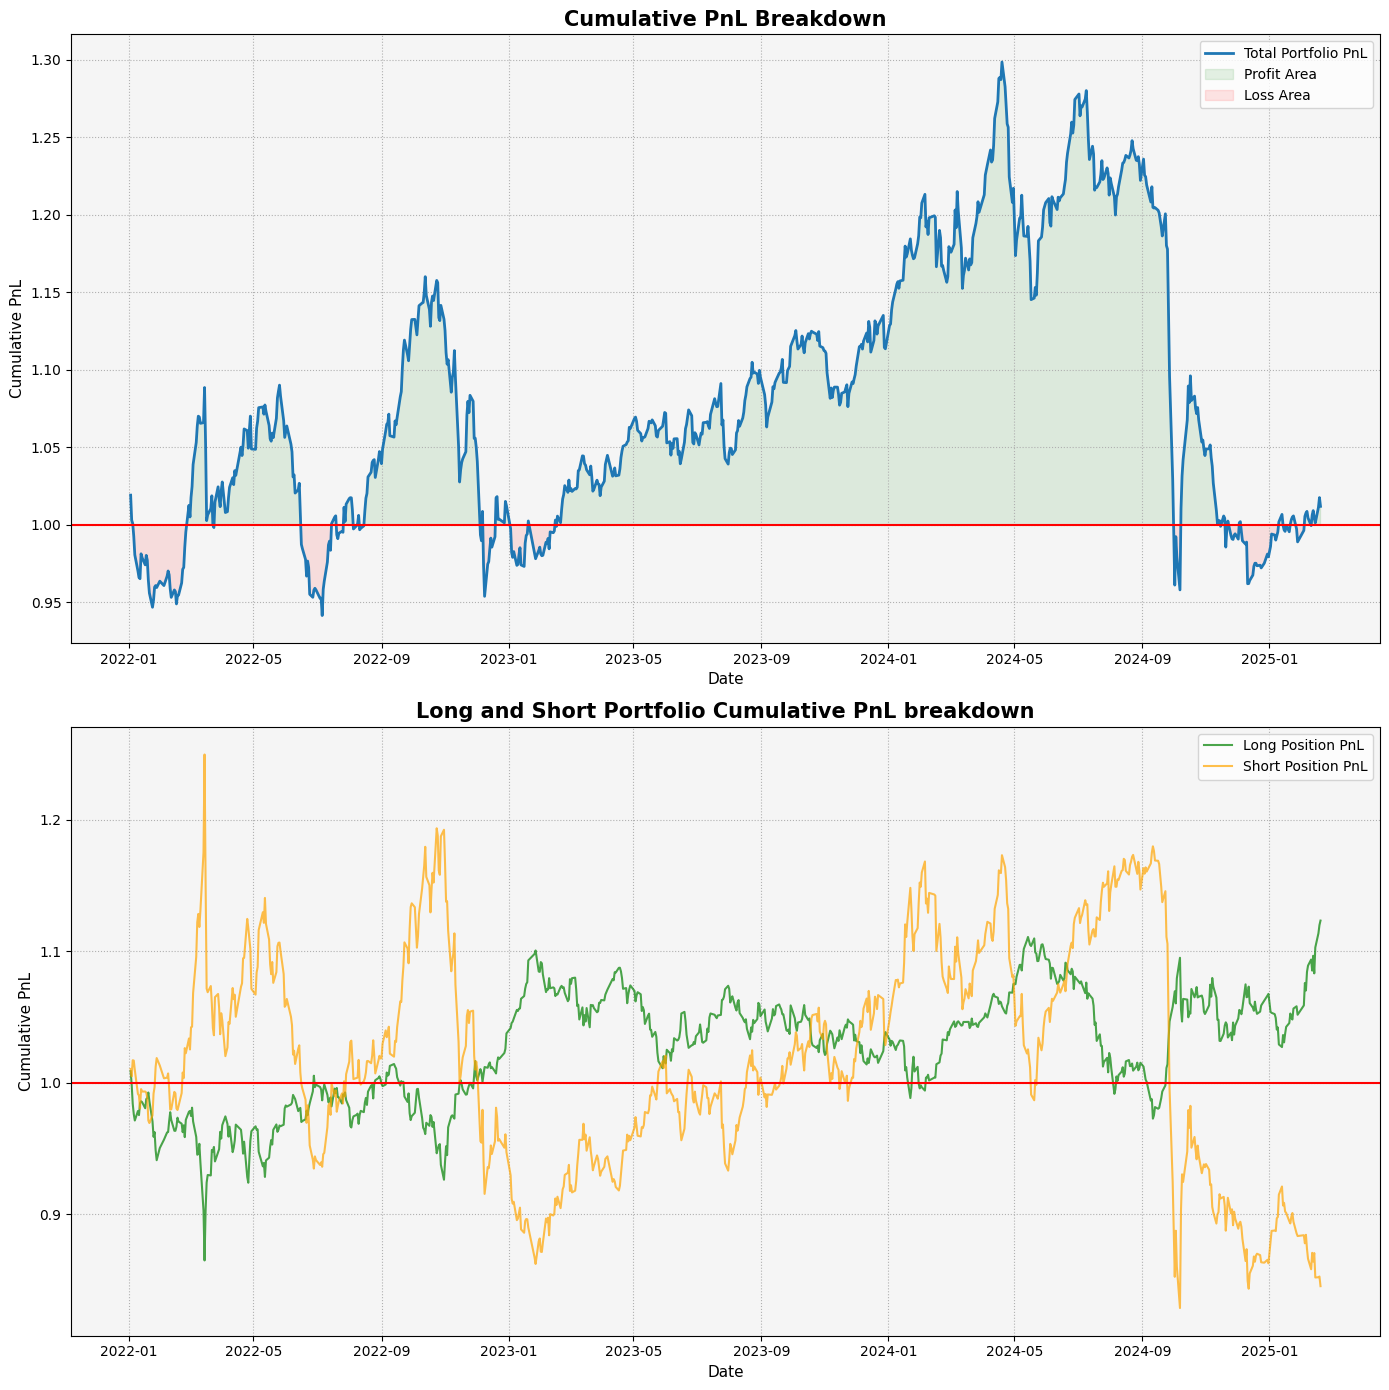

In [14]:
def plot_pnl(pnl, long_pnl, short_pnl):
    """
    Function to visualize the total PnL, long portfolio PnL and short portfolio PnL for the period
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))
    ax1.plot(pnl, label='Total Portfolio PnL', linewidth=2)
    ### Add baseline for total PnL ###
    ax1.axhline(y=1, color='red', linestyle='-')
    ### Fill profit and loss areas based on portfolio PnL ###
    pnl = pd.to_numeric(pnl, errors='coerce').astype(float)
    ax1.fill_between(pnl.index, pnl, 1, where=(pnl > 1), interpolate=True, color='green', alpha=0.1, label="Profit Area")
    ax1.fill_between(pnl.index, pnl, 1, where=(pnl <= 1), interpolate=True, color='red', alpha=0.1, label="Loss Area")
    ax1.set_title('Cumulative PnL Breakdown', fontsize=15, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=11)
    ax1.set_ylabel('Cumulative PnL', fontsize=11)
    ax1.legend(fontsize=10)
    ax1.grid(True, linestyle=':')
    ax1.set_facecolor('whitesmoke')
    ### Subplot for long and short breakdown ###
    ax2.plot(long_pnl, label='Long Position PnL', linestyle='-', color='green',alpha=0.7)
    ax2.plot(short_pnl, label='Short Position PnL', linestyle='-', color='orange',alpha=0.7)
    ### Add baseline for long and short positions ###
    ax2.axhline(y=1, color='red', linestyle='-')
    ax2.set_title('Long and Short Portfolio Cumulative PnL breakdown', fontsize=15, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=11)
    ax2.set_ylabel('Cumulative PnL', fontsize=11)
    ax2.legend(fontsize=10)
    ax2.grid(True, linestyle=':')
    ax2.set_facecolor('whitesmoke')
    ### Format x-axis labels for date ###
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.tight_layout()
    plt.savefig('Cumulative_Return.png')
    plt.show()

plot_pnl(pnl, long_pnl, short_pnl)

### The portfolio appears to have a decent final PnL, the short portfolio appears to have the larger drawdown that impacts the final portfolio PnL. Notable drawdowns on the short side occured in Jun22 (-13.5%), Nov22 (-18.7%) and Sept24 (-23.5%), which coincide with major bullish rallies, causing the underperformance of the short positions in those period. I will now drill into more details on portfolio performance. ###

In [12]:
def compute_performance(pnl, portfolio_return, risk_free_rate=0.0374):
    """
    Function to compute some commonly seen performance metric to measure the effectiveness of the strategy
    Assume 10-year Hong Kong government bond yield as the risk-free rate. (As of 2025.02.20 - 3.74%)
    """
    cumulated_return = pnl.iloc[-1] - 1
    n_years = len(portfolio_return)/252
    annualized_return = (1 + cumulated_return) ** (n_years) - 1
    annualized_vol = portfolio_return.std()*(252**0.5)
    sharpe = (annualized_return - risk_free_rate) / annualized_vol
    running_max = pnl.cummax()
    drawdown = (pnl - running_max)/running_max
    max_drawdown = drawdown.min()
    calmar = annualized_return / abs(max_drawdown)
    summary={'Cumulated Retun':cumulated_return, 'Annualized Return':annualized_return,
            'Annualized Volatility':annualized_vol, 'Sharpe Ratio':sharpe, 'Max Drawdown':max_drawdown,
            'Calmar Ratio':calmar}
    return summary
    
result = compute_performance(pnl, port_return)
print('Under the assumption of a 3.74% risk-free rate, the strategy yields:')
for metric, value in result.items():
    print(f"{metric}: {value:.4f}")

Under the assumption of a 3.74% risk-free rate, the strategy yields:
Cumulated Retun: 0.0120
Annualized Return: 0.0369
Annualized Volatility: 0.1576
Sharpe Ratio: -0.0032
Max Drawdown: -0.2621
Calmar Ratio: 0.1408
